In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ------------------ DQN Model ------------------
class DQN(nn.Module):
    def __init__(self, input_dim, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.out = nn.Linear(256, n_actions)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)


# ------------------ DQN Model ------------------
class DQN(nn.Module):
    def __init__(self, input_dim, n_actions):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )

    def forward(self, x):
        return self.net(x)

# ------------------ Replay Buffer ------------------
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        return (
            torch.tensor(np.array(states), dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(np.array(next_states), dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)

# ------------------ Environment ------------------
class PlayActivityEnv:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.index = 0

    def reset(self):
        self.index = 0
        return self.X[self.index]

    def step(self, action):
        correct_action = self.y[self.index]
        reward = 1 if action == correct_action else -1
        self.index += 1
        done = self.index >= len(self.X)
        next_state = self.X[self.index] if not done else None
        return next_state, reward, done

# ------------------ Train Function ------------------
def train_dqn(X, y, n_actions, num_episodes=10, batch_size=64, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995):
    input_dim = X.shape[1] * X.shape[2]
    policy_net = DQN(input_dim, n_actions).to(device)
    target_net = DQN(input_dim, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
    replay_buffer = ReplayBuffer()

    env = PlayActivityEnv(X, y)
    losses = []

    for episode in range(num_episodes):
        state = env.reset().flatten()
        total_reward = 0
        done = False

        while not done:
            if random.random() < epsilon:
                action = random.randint(0, n_actions - 1)
            else:
                with torch.no_grad():
                    q_values = policy_net(torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0))
                    action = torch.argmax(q_values).item()

            next_state_raw, reward, done = env.step(action)
            next_state = next_state_raw.flatten() if next_state_raw is not None else np.zeros_like(state)

            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                q_values = policy_net(states.to(device)).gather(1, actions.to(device).unsqueeze(1)).squeeze()
                next_q_values = target_net(next_states.to(device)).max(1)[0]
                expected_q_values = rewards.to(device) + gamma * next_q_values * (1 - dones.to(device))

                loss = nn.MSELoss()(q_values, expected_q_values.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

        if episode % 2 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        print(f"🎯 Episode {episode + 1}/{num_episodes} | Total reward: {total_reward} | Epsilon: {epsilon:.3f}")

    return policy_net, losses


In [ ]:
import numpy as np
import pandas as pd
import random
import os
import json

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Fix GPU randomness for reproducibility (optional)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

def interpolate_missing_data(data):
    """Interpolates missing numeric values and removes all remaining NaNs."""
    # Ensure numeric dtypes are inferred
    data = data.infer_objects(copy=False)

    # Preserve non-numeric columns (e.g., 'Frame')
    frame_col = data['Frame'] if 'Frame' in data.columns else None

    # Drop non-numeric columns for processing
    numeric_data = data.drop(columns=['Frame'], errors='ignore')

    # Replace 0s with NaN (assumed to be missing keypoints)
    numeric_data = numeric_data.replace(0, np.nan)

    # Interpolate first using linear interpolation over the index
    numeric_data = numeric_data.interpolate(method='linear', limit_direction='both')

    # Forward-fill and backward-fill to handle edge NaNs
    numeric_data = numeric_data.ffill().bfill()

    # Final check – force fill any residual NaNs (if any)
    numeric_data = numeric_data.fillna(0)

    # Reattach non-numeric columns, if they exist
    if frame_col is not None:
        numeric_data.insert(0, 'Frame', frame_col)

    return numeric_data

def load_data_intera(folder_path, window_size=75, step_size=37):
    """
    Loads CSV files directly from `folder_path`, interpolates missing values,
    slices the data into sliding windows, and assigns labels based on file names.
    
    Files with names containing '(Intera-)' are assigned the label 'intera-'.
    All other files are assigned the label 'non-intera'.
    """
    X, y = [], []
    
    # Define the two classes with fixed label mapping.
    label_map = {"intera-": 0, "non-intera": 1}

    # List CSV files in the given folder
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            data = pd.read_csv(file_path)
            
            # Ensure a 'Frame' column exists
            if 'Frame' not in data.columns:
                data.insert(0, "Frame", range(1, len(data) + 1))
            
            data = interpolate_missing_data(data)
            data = data.drop(columns=['Frame'], errors='ignore')

            # Determine label based on file name
            if "(Intera-)" in file:
                label = label_map["intera-"]
            else:
                label = label_map["non-intera"]

            # Generate sliding windows from the data
            for start in range(0, len(data) - window_size + 1, step_size):
                window = data[start:start + window_size]
                X.append(window)
                y.append(label)

    return np.array(X, dtype='float32'), np.array(y), label_map

# Path to your specific folder containing the files
folder_path = r"E:\Projects\CRC Projects\output_keypoints7_5_2"

X_intera, y_intera, label_map = load_data_intera(folder_path, window_size=75, step_size=37)

print("✅ Loaded:", X_intera.shape, y_intera.shape)

# Save the label mapping to a JSON file
with open("label_map_intera_2.json", "w") as f:
    json.dump(label_map, f)


✅ Loaded: (6442, 75, 74) (6442,)


In [4]:
n_classes = len(label_map)
model, loss_log = train_dqn(X_intera, y_intera, n_actions=n_classes, num_episodes=10000)
torch.save(model.state_dict(), "dqn_model_child_2.pth")
print("✅ Model saved to dqn_model_child_2.pth")

🎯 Episode 1/10000 | Total reward: -44 | Epsilon: 0.995
🎯 Episode 2/10000 | Total reward: 20 | Epsilon: 0.990
🎯 Episode 3/10000 | Total reward: 16 | Epsilon: 0.985
🎯 Episode 4/10000 | Total reward: 176 | Epsilon: 0.980
🎯 Episode 5/10000 | Total reward: 164 | Epsilon: 0.975
🎯 Episode 6/10000 | Total reward: 316 | Epsilon: 0.970
🎯 Episode 7/10000 | Total reward: 250 | Epsilon: 0.966
🎯 Episode 8/10000 | Total reward: 186 | Epsilon: 0.961
🎯 Episode 9/10000 | Total reward: 294 | Epsilon: 0.956
🎯 Episode 10/10000 | Total reward: 332 | Epsilon: 0.951
🎯 Episode 11/10000 | Total reward: 338 | Epsilon: 0.946
🎯 Episode 12/10000 | Total reward: 322 | Epsilon: 0.942
🎯 Episode 13/10000 | Total reward: 360 | Epsilon: 0.937
🎯 Episode 14/10000 | Total reward: 420 | Epsilon: 0.932
🎯 Episode 15/10000 | Total reward: 402 | Epsilon: 0.928
🎯 Episode 16/10000 | Total reward: 394 | Epsilon: 0.923
🎯 Episode 17/10000 | Total reward: 540 | Epsilon: 0.918
🎯 Episode 18/10000 | Total reward: 604 | Epsilon: 0.914
🎯 E

In [5]:
np.save("X_intera.npy", X_intera)
np.save("y_intera.npy", y_intera)

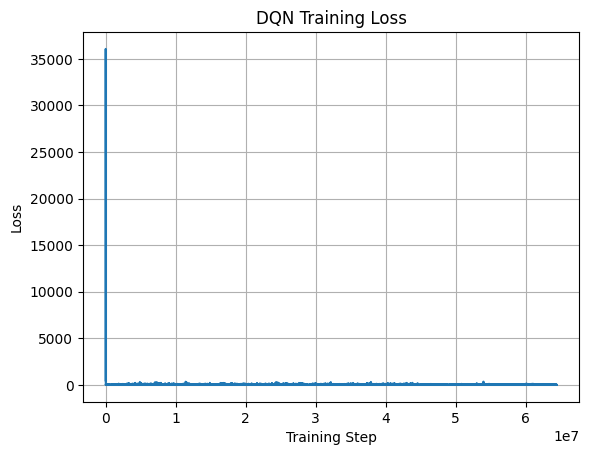

In [6]:
import matplotlib.pyplot as plt

plt.plot(loss_log)
plt.title("DQN Training Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()



✅ Using device: cuda
[0] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[1] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[2] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[3] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[4] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[5] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[6] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.88
[7] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.88
[8] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.88
[9] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[10] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.88
[11] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[12] ✅ Actual: intera-         | Predicte

C:\Users\sokea\AppData\Local\Temp\ipykernel_26948\313629748.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load("dqn_model_child_2.pth

[104] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[105] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[106] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[107] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[108] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[109] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[110] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[111] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[112] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[113] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[114] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[115] ✅ Actual: intera-         | Predicted: intera-         | Confidence: 0.87
[116] ✅ Actual: intera-         | Predic

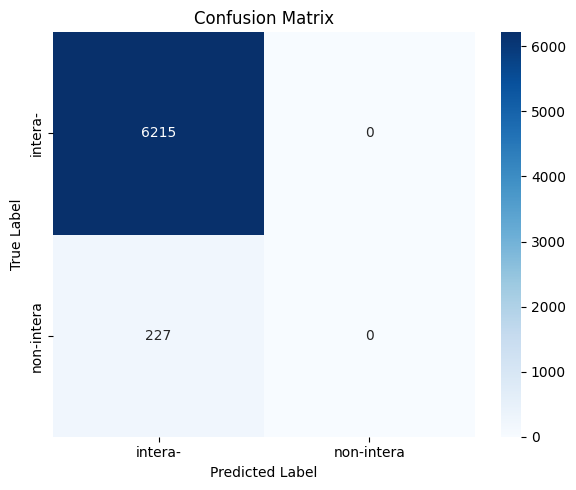


📋 Classification Report:
              precision    recall  f1-score   support

     intera-       0.96      1.00      0.98      6215
  non-intera       0.00      0.00      0.00       227

    accuracy                           0.96      6442
   macro avg       0.48      0.50      0.49      6442
weighted avg       0.93      0.96      0.95      6442



c:\Users\sokea\anaconda3\envs\q-table\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sokea\anaconda3\envs\q-table\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sokea\anaconda3\envs\q-table\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
import torch
import json
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# === 0. Setup Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# === 1. Load Data ===
X_intera = np.load("X_intera.npy")
y_intera = np.load("y_intera.npy")

# === 2. Define Model (matching training version) ===
class DQN(nn.Module):
    def __init__(self, input_dim, n_actions):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )

    def forward(self, x):
        return self.net(x)

# === 3. Load label map ===
with open("label_map_intera_2.json", "r") as f:
    label_map = json.load(f)
idx_to_label = {v: k for k, v in label_map.items()}
label_names = [idx_to_label[i] for i in range(len(label_map))]

# === 4. Load Model ===
input_dim = X_intera.shape[1] * X_intera.shape[2]
n_classes = len(label_map)

policy_net = DQN(input_dim=input_dim, n_actions=n_classes).to(device)
policy_net.load_state_dict(torch.load("dqn_model_child_2.pth", map_location=device))
policy_net.eval()

# === 5. Predict and Evaluate ===
correct = 0
total = len(X_intera)
y_true = []
y_pred = []

for i in range(total):
    window = X_intera[i] / 500.0
    flat_state = window.flatten()
    state_tensor = torch.tensor(flat_state, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        q_values = policy_net(state_tensor)
        predicted_idx = torch.argmax(q_values).item()
        confidence = torch.softmax(q_values, dim=1).max().item()

    actual_idx = y_intera[i]
    predicted_label = idx_to_label[predicted_idx]
    actual_label = idx_to_label[actual_idx]

    y_true.append(actual_idx)
    y_pred.append(predicted_idx)

    is_correct = "✅" if predicted_idx == actual_idx else "❌"
    print(f"[{i}] {is_correct} Actual: {actual_label:<15} | Predicted: {predicted_label:<15} | Confidence: {confidence:.2f}")

    if predicted_idx == actual_idx:
        correct += 1

# === 6. Accuracy ===
accuracy = correct / total * 100
print(f"\n🎯 Overall Accuracy: {accuracy:.2f}%")

# === 7. Confusion Matrix ===
print("\n📊 Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Optional: Pretty printed with labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# === 8. Classification Report ===
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_names))
